# 1 - Inicialización y carga de datos

## 1.1. Librerias

In [1]:
import os, types
import pandas as pd
import itertools
import scipy
import itertools 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency


from botocore.client import Config
import ibm_boto3

def __iter__(self): 
    return 0

%matplotlib inline

In [2]:
from pandas.core.common import SettingWithCopyWarning
import warnings

warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

## 1.3. Fuciones

In [3]:
def cramers_corrected_stat(confusion_matrix):
    """ calculate Cramers V statistic for categorical-categorical association.
        uses correction from Bergsma and Wicher, 
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    chi2 = scipy.stats.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1)))

## 1.3.  Carga de datos

In [4]:
# Carga de los datos
df = pd.read_csv('../src/data/ds_job.csv')

# 2. Análisis de los datos

**Descripción de los datos**

    • empleado_id: ID único por candidato
    • ciudad: código de la ciudad
    • indice_desarrollo_ciudad: índice de desarrollo de la ciudad en escala
    • genero: Género del candidato
    • experiencia_relevante: Experiencia relevante del candidato
    • universidad_matriculado: Tipo de curso universitario en el que se encuentra matriculado
    • nivel_educacion: Nivel educativo del candidato 
    • educacion: Educación 
    • experiencia: Experiencia en años del candidato
    • tamaño_compañia: Número de empleados en el empleador actual
    • tipo_compañia: Tipo de actual empleador
    • ultimo_nuevo_trabajo: Diferencia en años entre el trabajo actual y el anterior
    • horas_formacion: horas de formación completadas
    • target: 0 –No busca cambio de trabajo, 1 –Busca un cambio de trabajo

## 2.1. Análisis inicial

In [5]:
# El Id del empleado pasa a ser el índice del data frame
df.set_index('empleado_id', inplace=True)

In [6]:
# Mostramos la información de cada variable
pd.concat([df.head(), df.sample(5), df.tail()], axis=0)

,ciudad,indice_desarrollo_ciudad,genero,experiencia_relevante,universidad_matriculado,nivel_educacion,educacion,experiencia,tamano_compania,tipo_compania,ultimo_nuevo_trabajo,horas_formacion,target
empleado_id,,,,,,,,,,,,,
8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1.0
29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
11561,city_21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0.0
33241,city_115,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52,1.0
666,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0
10003,city_103,0.920,Female,No relevent experience,no_enrollment,Masters,Humanities,3,NaN,NaN,2,21,0.0
22572,city_76,0.698,NaN,No relevent experience,no_enrollment,Graduate,STEM,4,10000+,Pvt Ltd,1,138,1.0
21617,city_134,0.698,NaN,No relevent experience,no_enrollment,NaN,NaN,NaN,NaN,NaN,never,45,0.0
26111,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,Humanities,8,10000+,Pvt Ltd,1,21,0.0


In [7]:
# dimensiones del dataframe
df.shape

(19158, 13)

In [8]:
# Variables/columnas del dataframe
df.columns.values

array(['ciudad', 'indice_desarrollo_ciudad', 'genero',
       'experiencia_relevante', 'universidad_matriculado',
       'nivel_educacion', 'educacion', 'experiencia', 'tamano_compania',
       'tipo_compania', 'ultimo_nuevo_trabajo', 'horas_formacion',
       'target'], dtype=object)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19158 entries, 8949 to 23834
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ciudad                    19158 non-null  object 
 1   indice_desarrollo_ciudad  19158 non-null  float64
 2   genero                    14650 non-null  object 
 3   experiencia_relevante     19158 non-null  object 
 4   universidad_matriculado   18772 non-null  object 
 5   nivel_educacion           18698 non-null  object 
 6   educacion                 16345 non-null  object 
 7   experiencia               19093 non-null  object 
 8   tamano_compania           13220 non-null  object 
 9   tipo_compania             13018 non-null  object 
 10  ultimo_nuevo_trabajo      18735 non-null  object 
 11  horas_formacion           19158 non-null  int64  
 12  target                    19158 non-null  float64
dtypes: float64(2), int64(1), object(10)
memory usage: 2.0+ MB


Los datos proporcionados están formados por 13 variables, de las cuales una de ella es la variable objetivo (target). Esta nos indica si el empleado quiere cambiar de trabajo o no. Esta información se proporciona en código binario, es decir, 1 si quiere cambiar de trabajo y 0 si no quiere cambiar. Por otro lado, hay un total de 19158 entradas (filas).

Adicionalmente, se puede observar que hay valores nulos en algunas de estas variables, estas seran tratadas en la sección *XXXXXX*.

## 2.2. Análisis de la variable objetivo

In [10]:
# División del dataset 
X, y = df.drop('target', axis=1), df['target']

In [11]:
# Determinar la cantidad de valores en la variable objetivo 
y.value_counts()

0.0    14381
1.0     4777
Name: target, dtype: int64

In [12]:
# Determino el % de 1 y 0 en la variable objetivo 
print('Cantidad de empleados que NO se quieren ir:', round(y.value_counts()[0]/len(df) * 100,2), '%')
print('Cantidad de empleados que se quieren ir:', round(y.value_counts()[1]/len(df) * 100,2), '%')

Cantidad de empleados que NO se quieren ir: 75.07 %
Cantidad de empleados que se quieren ir: 24.93 %


Los datos NO están altamente desbalanceados. 

## 2.2. Análisis de los valores nulos

In [13]:
# Determinar el porcentaje de valores nulos en cada columna 
pd.DataFrame(X.isnull().sum() / len(X) * 100, columns=['% NaN'])

,% NaN
ciudad,0.000000
indice_desarrollo_ciudad,0.000000
genero,23.530640
experiencia_relevante,0.000000
universidad_matriculado,2.014824
nivel_educacion,2.401086
educacion,14.683161
experiencia,0.339284
tamano_compania,30.994885
tipo_compania,32.049274


Las variables **genero, universidad_matriculado, nivel_educacion, educacion, experiencia, tamano_compania, tipo_compania y ultimo_nuevo_trabajo** tiene valores nulos. Por tanto, estas variables serán tratadas. 

In [ ]:
# Mantenemos las filas con valores No nulos en al menos 7 columnas
df = df[df.isnull().sum(axis=1) <= 7]

# 3. Exploración de los datos

Antes de proceder a la exploración de los datos se divide el dataset en variables numéricas y variable categóricas. En esta sección se evaluarán de forma separada. 

In [20]:
# Dividir el dataset en variables numéricas y categóricas
numerical_X = X.select_dtypes(include=[np.number])
categorical_X = X.select_dtypes(include=[np.object])

## 3.1 Variables numéricas

### 3.1.1. Distribuciones

In [23]:
# Estadística descriptiva de las variables numéricas
numerical_X.describe()

,indice_desarrollo_ciudad,horas_formacion
count,19158.000000,19158.000000
mean,0.828848,65.366896
std,0.123362,60.058462
min,0.448000,1.000000
25%,0.740000,23.000000
50%,0.903000,47.000000
75%,0.920000,88.000000
max,0.949000,336.000000


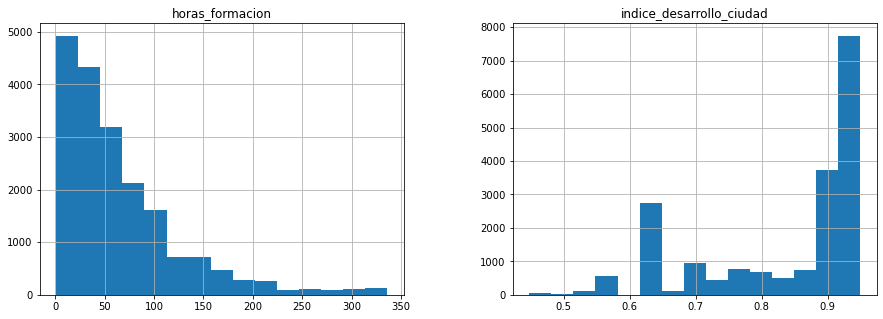

In [31]:
# Mostrar los histogramas de las variables numéricas
numerical_X.hist(bins=15, figsize=(15, 5))
plt.show()

La variable**horas_formacion** tiene una cola larga (right Skewed - positevely distribution)

### 3.1.2 Outliers

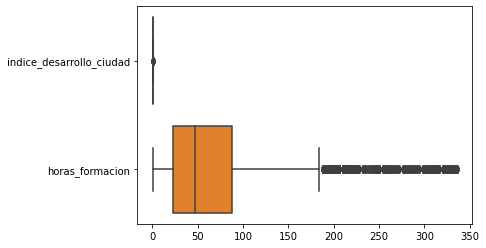

In [25]:
# Boxplot de las variables numéricas
sns.boxplot(data=numerical_X, orient='h')

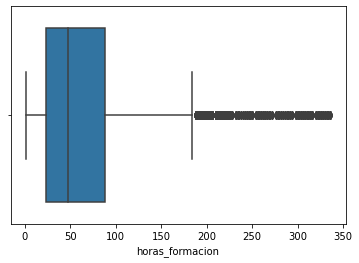

In [26]:
# Boxplot de la variable horas_formacion
sns.boxplot(x=numerical_X['horas_formacion'])

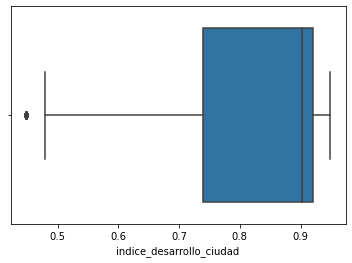

In [27]:
# Boxplot de la variable indice_desarrollo_ciudad
sns.boxplot(x=numerical_X['indice_desarrollo_ciudad'])

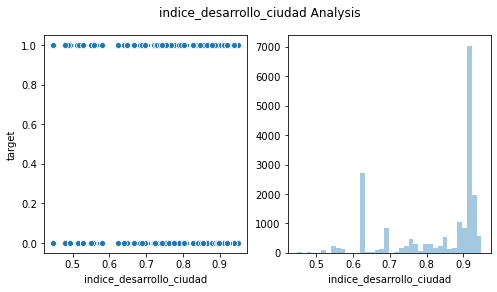

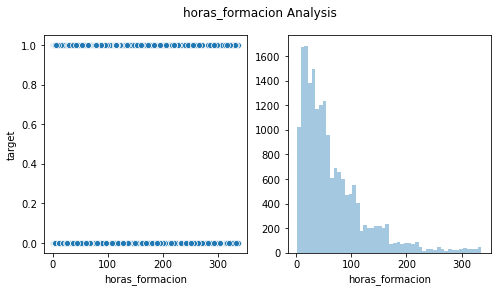

In [28]:
for v in numerical_X:
    fig, ax = plt.subplots(1,2,figsize=(8,4))
    sns.scatterplot(x= v, y=y, data=numerical_X, ax=ax[0])
    sns.distplot(numerical_X[v], kde=False, ax=ax[1])
    fig.suptitle(str(v) + ' Analysis')

Vemos que las variables numéricas tiene valores atípicos pero estos no se pueden considerar como tal, ya que están dentro de la misma escala y le dan valor al modelo según como se han distribuido y representado.  

**(COMPROBAR)**

### 3.1.3. Correlograma 

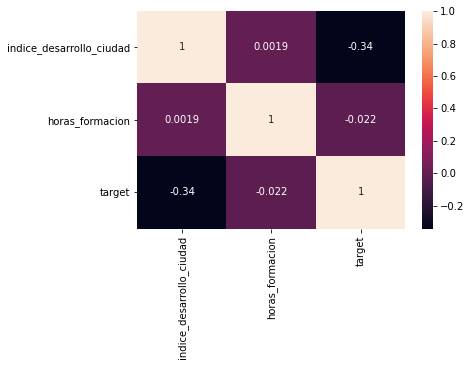

In [32]:
# Correlagroma variables numericas
sns.heatmap(df.corr(), annot=True)

Las variables numéricas no tienen una alta correlación con la variable objetivo ni entre ellas. 

## 3.2. Variables categóricas

### 3.2.1. Distribuciones

In [16]:
# Estadística descriptiva de las variables categóricas
categorical_X.describe()

,ciudad,genero,experiencia_relevante,universidad_matriculado,nivel_educacion,educacion,experiencia,tamano_compania,tipo_compania,ultimo_nuevo_trabajo
count,19158,14650,19158,18772,18698,16345,19093,13220,13018,18735
unique,123,3,2,3,5,6,22,8,6,6
top,city_103,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,50-99,Pvt Ltd,1
freq,4355,13221,13792,13817,11598,14492,3286,3083,9817,8040


In [33]:
new_index = [21, 5, 4, 3, 6, 2, 7, 10, 9, 8, 15, 11,
       14, 1, 0, 16, 12, 13, 17, 19, 18, 20]

In [34]:
experiencia = categorical_X['experiencia'].value_counts()

In [35]:
experiencia.index = new_index

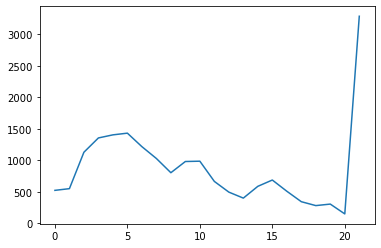

In [36]:
experiencia.sort_index().plot()

In [94]:
# valores por cada variable categórica
for column in categorical_X.columns.values:
    print(column.upper())
    print(categorical_X[column].value_counts())
    print('\n')

CIUDAD
city_103    4355
city_21     2702
city_16     1533
city_114    1336
city_160     845
            ... 
city_111       3
city_121       3
city_129       3
city_140       1
city_171       1
Name: ciudad, Length: 123, dtype: int64


GENERO
Male      13221
Female     1238
Other       191
Name: genero, dtype: int64


EXPERIENCIA_RELEVANTE
Has relevent experience    13792
No relevent experience      5366
Name: experiencia_relevante, dtype: int64


UNIVERSIDAD_MATRICULADO
no_enrollment       13817
Full time course     3757
Part time course     1198
Name: universidad_matriculado, dtype: int64


NIVEL_EDUCACION
Graduate          11598
Masters            4361
High School        2017
Phd                 414
Primary School      308
Name: nivel_educacion, dtype: int64


EDUCACION
STEM               14492
Humanities           669
Other                381
Business Degree      327
Arts                 253
No Major             223
Name: educacion, dtype: int64


EXPERIENCIA
>20    3286
5      143

### 3.2.2. Correlograma

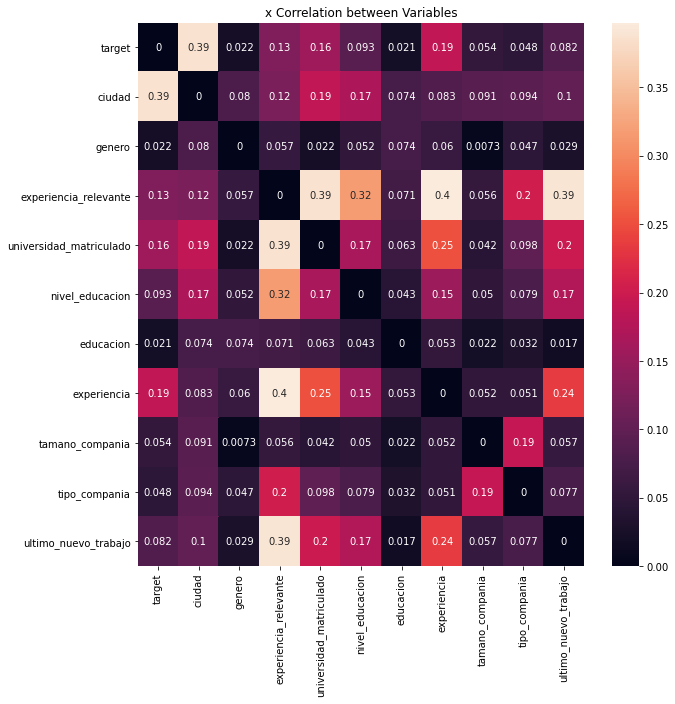

In [81]:
cols = ['target','ciudad', 'genero', 'experiencia_relevante', 'universidad_matriculado', 'nivel_educacion', 
        'educacion', 'experiencia', 'tamano_compania', 'tipo_compania', 'ultimo_nuevo_trabajo',  ]

corrM = np.zeros((len(cols),len(cols)))
# there's probably a nice pandas way to do this
for col1, col2 in itertools.combinations(cols, 2):
    idx1, idx2 = cols.index(col1), cols.index(col2)
    corrM[idx1, idx2] = cramers_corrected_stat(pd.crosstab(df[col1], df[col2]))
    corrM[idx2, idx1] = corrM[idx1, idx2]

corr = pd.DataFrame(corrM, index=cols, columns=cols)
fig, ax = plt.subplots(figsize=(10, 10))
ax = sns.heatmap(corr, annot=True, ax=ax); ax.set_title("x Correlation between Variables");

In [82]:
# Compruebo lo valores de la tabla  (no es necesario)
cramers_corrected_stat(pd.crosstab(df['ciudad'], df['genero']))

0.0797739711609101

In [79]:
# Compruebo lo valores de la tabla  (no es necesario)
cramers_corrected_stat(pd.crosstab(df['target'], df['target']))

0.9998605564219094

La variable más correlacionada con la variable objetivo es **ciudad** (0.39), seguido de **experiencia** (0.19), **universidad_matriculado** (0.16), y **experiencia_relevante** (0.13).

Entre el resto de variables, las que están más correlacionadas son:
- (0.39) experiencia_relevante y experiencia.
- (0.39) experiencia_relevante y universidad_matriculado.
- (0.39) experiencia_relevante y ultimo_nuevo_trabajo.
- (0.32) experiencia_relevante y nivel_educacion.
- (0.25) universidad_matriculado y experiencia.
- (0.20) universidad_matriculado y ultimo_nuevo_trabajo.
- (0.19) tamano_compania y tipo_compania.
- (0.17) nivel_educacion y ciudad.
- (0.17) nivel_educacion y universidad_matriculado.

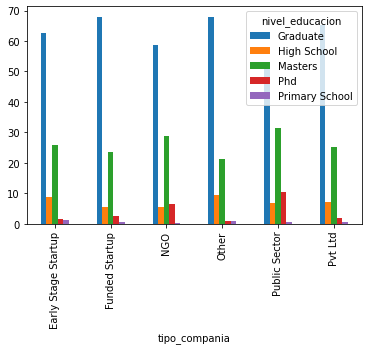

In [88]:
# Gráfico de barras entre variables catergóricas
plot = pd.crosstab(index=categorical_X['tipo_compania'],
            columns=categorical_X['nivel_educacion']).apply(lambda r: r/r.sum() *100,
                                              axis=1).plot(kind='bar')

## 3.3 Conclusion de la exploración de datos

__________ COMPLETAR_______ 

# 4. Procesamiento/preparación de los datos

En esta sección se tratan los siguientes temas:
- Tratamiento de nulos
- Tramiento de variables categóricas. 
- Se eliminan variables (Ver si es necesario)

In [108]:
# Para visualizar mientras se hace el tratamiento (se puede eliminar)
df.head(5)

,ciudad,indice_desarrollo_ciudad,genero,experiencia_relevante,universidad_matriculado,nivel_educacion,educacion,experiencia,tamano_compania,tipo_compania,ultimo_nuevo_trabajo,horas_formacion,target
empleado_id,,,,,,,,,,,,,
8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1.0
29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
11561,city_21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0.0
33241,city_115,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52,1.0
666,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0


## 4.1. Tratamiento de nulos

Las variables categóricas **genero, universidad_matriculado, nivel_educacion, educacion, experiencia, tamano_compania, tipo_compania y ultimo_nuevo_trabajo** tiene valores nulos.

### 4.1.1 Feature Engineering

In [44]:
# BORRAR
numerical_X = X.select_dtypes(include=[np.number])
categorical_X = X.select_dtypes(include=[np.object])

In [45]:
# Sustituir NaN de universidad_matriculado
for i in range(len(categorical_X)):
    if categorical_X.iloc[i,4] == 'Primary School' or categorical_X.iloc[i,4] == 'High School':
        if categorical_X.iloc[i,3] != 'no_enrollment' and categorical_X.iloc[i,3] != 'Full time course' and categorical_X.iloc[i,3] != 'Part time course':
            categorical_X.iloc[i,3] = 'no_enrollment'

## 4.1.2. Eliminar filas

In [ ]:
# Eliminar filas con muchos NaN
## COMPLETAR

## 4.1.3. Imputar NaN por valores aleatorios

In [57]:
# Completar NaN por valores aleatorios
categorical_X.genero.fillna(np.random.choice(categorical_X[categorical_X.genero.notnull()].genero.unique()), inplace =True)

## 4.1.4. Imputar NaN por una clase específica

**Variable ultimo_nuevo_trabajo**

In [46]:
# Remplazar por clase unknown
categorical_X['ultimo_nuevo_trabajo'] = categorical_X['ultimo_nuevo_trabajo'].fillna('Unknown')

**Variable tipo_compania**

In [47]:
# Remplazar por clase unknown
categorical_X['tipo_compania'] = categorical_X['tipo_compania'].fillna('Unknown')

**Variable tamano_compania**

In [48]:
# Remplazar por clase unknown
categorical_X['tamano_compania'] = categorical_X['tamano_compania'].fillna('Unknown')

**Variable nivel_educacion**

In [55]:
# Remplazar por clase unknown
categorical_X['nivel_educacion'] = categorical_X['nivel_educacion'].fillna('Unknown')

**Variable educacion**

In [49]:
# Remplazar por clase self-taught
categorical_X['educacion'] = categorical_X['educacion'].fillna('self-taught')

### 4.1.5. Imputar NaN por la clase más repetida

**Variable universidad_matriculado**

In [50]:
df['universidad_matriculado'].mode()

0    no_enrollment
dtype: object

In [51]:
categorical_X['universidad_matriculado'].fillna("no_enrollment", inplace = True)

**Variable experiencia**

In [52]:
df['experiencia'].mode()

0    >20
dtype: object

In [53]:
categorical_X['experiencia'].fillna(">20", inplace = True)

## 4.1.4. Comprobar valores nulos

In [58]:
# Comprobar el valor de nulos actuales
pd.DataFrame(categorical_X.isnull().sum() / len(X) * 100, columns=['% NaN'])

,% NaN
ciudad,0.0
genero,0.0
experiencia_relevante,0.0
universidad_matriculado,0.0
nivel_educacion,0.0
educacion,0.0
experiencia,0.0
tamano_compania,0.0
tipo_compania,0.0
ultimo_nuevo_trabajo,0.0


## 4.2. Tratamiento de variables categóricas

En esta sección se modifican las varaibles catergóricas:

- experiencia_relevante: Experiencia relevante del candidato -> LabelEncoding(0 – No, 1 – Sí)
- universidad_matriculado: Tipo de curso universitario en el que se encuentra matriculado -> OneHotEncoding
- nivel_educacion: Nivel educativo -> LabelEncoding
- educacion: Educación -> OneHotEncoding(NAN -> self-taught)
- experiencia: (Ver distribución) OneHotEncoding
- tamaño_compañia: Número de empleados en el empleador actual -> NAN -> Unknown y OneHotEncoding
- tipo_compañia: Tipo de actual empleador -> NAN -> Unknown y OneHotEncoding
- ultimo_nuevo_trabajo: Diferencia en años entre el trabajo actual y el anterior -> OneHotEncoding



# 5. Modelo